In [121]:
import urllib.request
import json
import time
import matplotlib.pyplot as plt
import seaborn
import re
from collections import Counter
import sqlite3

In [122]:
#посты
posts=[]
pagename='cooktech'
version='5.95'
token='ef94e788ef94e788ef94e788c0effe664feef94ef94e788b34224bf1f41589c76e180d4'
offsets=[0,100]
for offset in offsets:
    req = urllib.request.Request('https://api.vk.com/method/wall.get?domain=%s&count=100&access_token=%s&v=%s&offset=%s'  % (pagename, token, version, offset))
    response = urllib.request.urlopen(req) 
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    posts.extend(data['response']['items'])

In [123]:
#комменты
comments={}
owner_id="-170569428"
for post in posts:
    post_id=post['id']
    comments[post_id]=[]
    req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&count=100&access_token=%s&v=%s'  % (owner_id, post_id, token, version))
    response = urllib.request.urlopen(req) 
    result = response.read().decode('utf-8')
    data = json.loads(result) 
    comments[post_id].extend(data['response']['items'])

In [124]:
#длины постов и комментариев
posts_data=[]
for post in posts:
    post_data={}
    post_data['post_id'] = post['id']
    post_data['text'] = post['text']
    post_data['text_len'] = len(post['text'].split())
    post_data['data'] = time.ctime(int(post['date']))
    post_data['day']=post_data['data'].split()[0]
    regTag=re.compile('#.*?@', flags=re.DOTALL)
    tag=regTag.findall(post['text'])
    if len(tag)>0:
        post_data['tag']=tag[0][1:len(tag[0])-1]
    else:
        post_data['tag']='no tag'
    post_comments=[]
    ncomments=0
    comments_len_sum=0
    for comment in comments[post['id']]:
        ncomments+=1
        comment_data={}
        comment_data['comment_id']=comment['id']
        if 'text' in comment:
            comment_data['text']=comment['text']
            comment_data['text_len'] = len(comment['text'].split())
            comments_len_sum+=comment_data['text_len']
        comment_data['date']=time.ctime(int(post['date']))
        post_comments.append(comment_data)
    post_data['comments']=post_comments
    post_data['comments_avg_len']=comments_len_sum/ncomments
    posts_data.append(post_data)

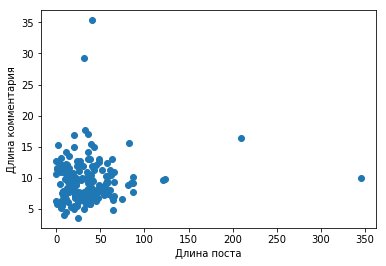

In [5]:
#график про длины
text_lens=[]
comment_lens=[]
for post in posts_data:
    text_lens.append(post['text_len'])
    comment_lens.append(post['comments_avg_len'])
plt.scatter(text_lens, comment_lens)
plt.xlabel("Длина поста")
plt.ylabel("Длина комментария")
plt.show()

In [125]:
graph_tags={}
for post in posts_data:
    if post['tag'] in graph_tags:
        graph_tags[post['tag']].append(post['text_len'])
    else:
        graph_tags[post['tag']]=[post['text_len']]
for tag in graph_tags:
    avg=sum(graph_tags[tag]) / len(graph_tags[tag])
    graph_tags[tag]=avg
tags=[]
lens=[]
for tag, text_len in graph_tags.items():
    tags.append(tag)
    lens.append(graph_tags[tag])


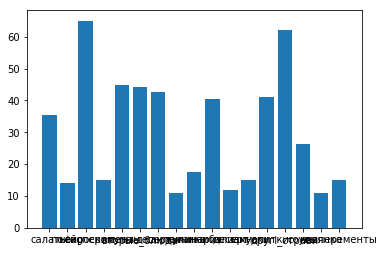

In [115]:
plt.bar(tags, lens)
plt.show()

In [126]:
graph_days={}
graph_days['Mon']=[]
graph_days['Tue']=[]
graph_days['Wed']=[]
graph_days['Thu']=[]
graph_days['Fri']=[]
graph_days['Sat']=[]
graph_days['Sun']=[]
week=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for post in posts_data:
    if post['day'] in graph_tags:
        graph_days[post['day']].append(post['text_len'])
    else:
        graph_days[post['day']].append(post['text_len'])
for day in graph_days:
    avg=sum(graph_days[day]) / len(graph_days[day])
    graph_days[day]=avg
days=[]
lens=[]
for day in week:
    days.append(day)
    lens.append(graph_days[day])

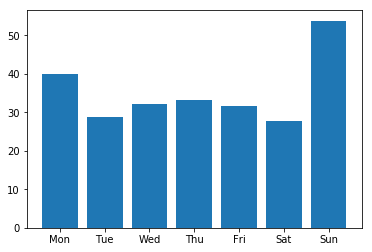

In [113]:
plt.bar(days, lens)
plt.show()

In [ ]:
#инфа об авторах
authors_info={}
for post in posts:
    post_id=post['id']
    for comment in comments[post_id]:
        if 'from_id' in comment:
            author_id = comment['from_id']
            if author_id not in authors_info.keys():
                req = urllib.request.Request('https://api.vk.com/method/users.get?user_ids=%s&fields=sex,bdate&access_token=%s&v=%s'  % (author_id, token, version))
                response = urllib.request.urlopen(req)
                result = response.read().decode('utf-8')
                data = json.loads(result)
                if 'error' in data:
                    continue
                author_info={}
                author_info['sex'] = data['response'][0]['sex']
                if 'bdate' in data['response'][0]:
                    author_info['bday'] = data['response'][0]['bdate']
                else: 
                    author_info['bday'] = 'unknown'
                authors_info[author_id]=author_info

In [ ]:
#тексты
plain_text=""
for post in posts_data:
    plain_text+=post['text']+'\n'
    for comment in post['comments']:
        if 'text' in comment:
            plain_text+=comment['text']+'\n'
with open('plain_text.txt','w', encoding='utf-8') as f:
    f.write(plain_text)
plain_text_no_punct= re.sub(r'[,.—–!?•:;"()1234567890>//]',r'', plain_text)


In [26]:
with open('stopwords-ru.json',encoding='utf-8') as f:
    stop_words = json.load(f)

In [ ]:
stop_words.extend(['-','а','что-то'])
no_stops=[]
for word in plain_text_no_punct.lower().split():
    if word not in stop_words:
        no_stops.append(word)
        no_stops_text+=word+' '
word_frequency = Counter(no_stops)

In [ ]:
words_30 = word_frequency.most_common(30)
words=[]
freqs=[]
for word in words_30:
    words.append(word[0])
    freqs.append(int(word[1]))
plt.barh(words, freqs)
plt.title('30 самых частых слов')
plt.xlabel("количество")
plt.ylabel("слово")
plt.savefig('30words.png')
plt.show()

In [45]:
import os
os.system(r"C:\hw\mystem.exe C:\hw\plain_text.txt C:\hw\lemm_text.txt -ln")

0

In [47]:
with open('lemm_text.txt',encoding='utf-8') as f:
    lemm_text=f.read()

In [ ]:
stop_words.extend(['это|этот','весь|все','из|иза','то|тот','быть|есть','cooktech??','будет|быть','чем|что','🤔??'])
stop_words.extend(['какой-то','тут|тута','он|оно|его','быть|было','я|мень'])
lemm_no_stops=[]
no_stops_text=''
for word in lemm_text.split():
    if word not in stop_words:
        lemm_no_stops.append(word)
        no_stops_text+=word.split('|', 1)[0]+' '
lemm_word_frequency = Counter(lemm_no_stops)

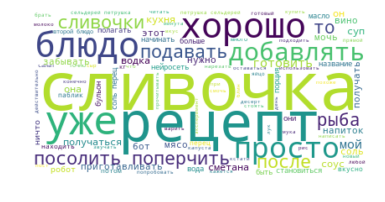

In [59]:
#облако
from wordcloud import WordCloud
cloud = WordCloud(background_color="white", max_words=100)
cloud.generate(no_stops_text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
cloud.to_file("post_cloud.png")

In [94]:
conn = sqlite3.connect('recipies.db')

In [95]:
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS posts(
        id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
        post_id INTEGER,
        tag TEXT,
        date TEXT,
        plain TEXT)''')
c.execute('''CREATE TABLE IF NOT EXISTS comments(
        id INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
        comment_id INTEGER,
        parent INTEGER,
        sex TEXT,
        bdate TEXT,
        plain TEXT)''')

In [96]:
for post in posts_data:
    c.execute('INSERT INTO posts (post_id, tag, date, plain) VALUES (?,?,?,?)', (post['post_id'], post['tag'], post['data'], post['text']))

In [99]:
conn.commit()

In [98]:
for post in posts:
    for comment in comments[post['id']]:
        if 'from_id' in comment:
            author_id=comment['from_id']
            if int(author_id)>0:
                sex=authors_info[author_id]['sex']
                bday=authors_info[author_id]['bday']
            else:
                sex='unknown'
                bday='unknown'
        else:
            sex='unknown'
            bday='unknown'
        if 'text' in comment:
            c.execute('INSERT INTO comments (comment_id, parent, sex, bdate, plain) VALUES (?,?,?,?,?)', (comment['id'], post['id'], sex, bday,comment['text']))
        else:
            c.execute('INSERT INTO comments (comment_id, parent, sex, bdate, plain) VALUES (?,?,?,?,?)', (comment['id'], post['id'], sex, bday,''))

167455952
158124115
226405639
257063685
336844965
379000747
148924650
284606366
148924650
158124115
205272357
145663206
102777077
9019973
260683566
157280719
176450378
235579930
216941404
164950926
191813153
47120802
335757526
191813153
191813153
49612118
279395664
16742377
47120802
178414281
178414281
157355
48364336
251872561
316352988
302887199
153805018
373092051
269965909
11992121
481573703
296395
228516995
228516995
4345205
496494084
236035225
45066450
28137055
207102703
304595161
224887407
360345849
541150426
308557806
539168661
197442437
297662186
509586912
510718961
92349774
166224331
396736793
422094203
368908018
166224331
108443564
336844965
422094203
157280719
4051328
274830317
235613992
11205077
399029999
61798743
243426800
213002723
254005742
166316
282706066
254588969
314931901
172769636
524378028
18772687
249417017
291124480
158035678
168344807
3366513
296395
12277815
998981
56723339
71017958
379000747
219274558
537284649
508131441
10343105
541022384
144349250
2266633
4

16742377
3497572
56376657
254005742
87733329
751696
535397458
336844965
460098887
211172564
187479025
134017545
358789943
33532336
191813153
13464433
329178132
140192911
379153509
16742377
195248298
7163994
6650906
105038972
151579469
336553780
15763071
1424885
282706066
187479025
11205077
241328035
417284
9019973
1101957
87733329
56252665
17350805
307943754
499550990
506398161
246123046
535397458
56252665
97290849
33532336
108443564
12670129
187952874
422094203
529101804
189625274
399029999
303946783
303946783
5830432
144743649
249417017
11205077
261269709
462657376
329178132
98374318
394882894
138741301
62701582
7412627
1424885
191813153
11315193
16742377
382008170
105038972
241328035
474672659
135243367
3830821
539548500
212354455
396736793
159209193
1730893
108443564
4051328
159209193
233405502
141962194
22942447
501512709
36022198
17734524
194541838
254005742
18320597
189625274
2783195
477879965
329178132
562753
359446260
5146355
5401601
56252665
235840421
501173
15157812
88454139

243426800
379000747
181896248
416750416
437328208
307861789
115258240
439993100
363168108
19559144
233822354
412973
191813153
17350805
193616076
139360978
56323744
481327665
519607167
185059821
2892222
7725472
108443564
52832408
4051328
303946783
161893765
405155659
13464433
87733329
144743649
427912157
318297
291378320
233405502
238958468
132495770
3430776
8377280
105038972
94716013
88454139
241328035
474287277
516592145
13464433
5108993
275925110
509260206
152450744
363168108
287934212
313636679
535397458
422094203
36022198
335757526
59356406
203464419
16790222
281593602
98666647
303946783
167794597
99277135
269965909
17350805
422094203
105038972
439993100
87733329
99863918
11205077
63515806
67920417
46233769
249417017
399029999
61798743
241328035
495268423
9019973
161893765
1770410
156042030
255400975
433643451
51300745
159209193
307549427
146923841
140192911
144520700
336844965
422094203
4051328
422094203
183517397
363168108
13464433
336844965
69415787
1044529
399029999
399029999
1

416750416
216941404
254230093
17564804
427312192
172063749
17350805
227283
132432074
474287277
22790258
260683566
85583770
417284
152681975
166224331
214414548
51300745
214414548
235613992
358789943
3497572
524848477
222900559
158124115
134017545
5830432
283130179
50072032
194043014
303946783
303946783
519754688
239376502
9019973
11205077
249525521
69037848
146028979
433508819
17350805
416750416
416750416
1424885
249205448
16742377
5108993
363168108
439993100
23773665
257061841
1424885
1424885
16742377
133399811
243426800
243426800
430404599
191813153
22790258
16249576
96594869
527448325
183820117
18048395
438016103
257063685
264378682
272843733
365211718
272843733
281593602
230661101
5108993
678342
218404003
191813153
359446260
191813153
219274558
164950926
496494084
177425575
506398161
9830129
16742377
227283
427312192
363168108
335031647
86078835
500926446
562753
243426800
297662186
98666647
108443564
183820117
335757526
257063685
336844965
1225951
36022198
46022209
17350805
5108993

191813153
358789943
166224331
22157719
22157719
222610219
497452428
4051328
99679760
443484584
95031831
66005376
153805018
362517761
507443464
507443464
507443464
507443464
200067701
166224331
297662186
358789943
505828641
336844965
62520386
399029999
62520386
191813153
66005376
105038972
241328035
175274405
11205077
430404599
4051328
294771821
358789943
191813153
336844965
22942447
5108993
17350805
199723514
46233769
337950432
16742377
228516995
7472919
166224331
303946783
4180365
336844965
69415787
5108993
54781516
33532336
506880297
678342
175274405
55490403
22790258
318991219
817743
38193859
430404599
29109029
2928711
391684307
382008170
244560941
105038972
169599777
258012545
499550990
8922948
279395664
132432074
241328035
315585344
4051328
17781990
4383729
187479025
194377444
175274405
242060561
108443564
274927313
341486002
242060561
10942531
166175817
157280719
336844965
10942531
223423941
291531425
244560941
175274405
326870214
9315196
222610219
19559144
138952143
382292386
22

5401601
302887199
464244590
356347604
219274558
356948627
316352988
266615620
257063685
495828970
249205448
272843733
145663206
284463639
284463639
166224331
63391344
250712017
257057208
145663206
505828641
4157980
432958856
5108993
239818120
288865081
216986377
54770
288865081
998981
288865081
225793833
17776326
335757526
268599516
17156434
466870501
187479025
167455952
143673913
504558094
17350805
6195903
187479025
117023549
366085904
413702762
51295937
5108993
151579469
191813153
25133502
152681975
678342
86078835
158124115
166224331
482711847
175274405
7725472
7725472
225793833
181496284
493594230
411034082
14758321
244560941
75892910
4051328
-81816725
302887199
55490403
151579469
151579469
344885625
166224331
33532336
152681975
33532336
175274405
416750416
228516995
518596794
169111065
228516995
50072032
493594230
462146021
233405502
398318860
12849019
4051328
241328035
500936719
55490403
496494084
454971272
174868083
108443564
169289730
474287277
257063685
272667995
61257994
5549